# Fetch Data and import necessary libraries

In [1]:
# !wget https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv
import numpy as np
import tensorflow as tf
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras import Sequential
from keras.layers import Dense,Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE 

In [2]:
data = pd.read_csv("creditcard.csv")

# important plotting functions

# Visualize the data

1. plot a countplot to check for imbalance in the Dataset

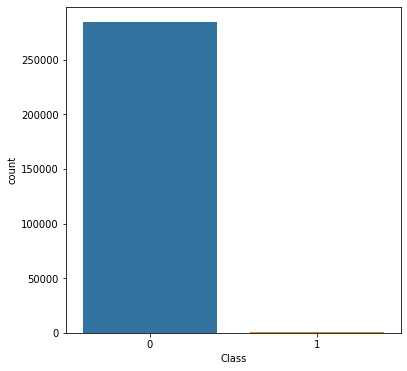

In [3]:
plt.figure(figsize=(6,6))
sb.countplot(x="Class",data=data)
plt.show()

2. check for skewness in the data. If skewness is present than we should apply necessary transfromations

<Figure size 864x576 with 0 Axes>

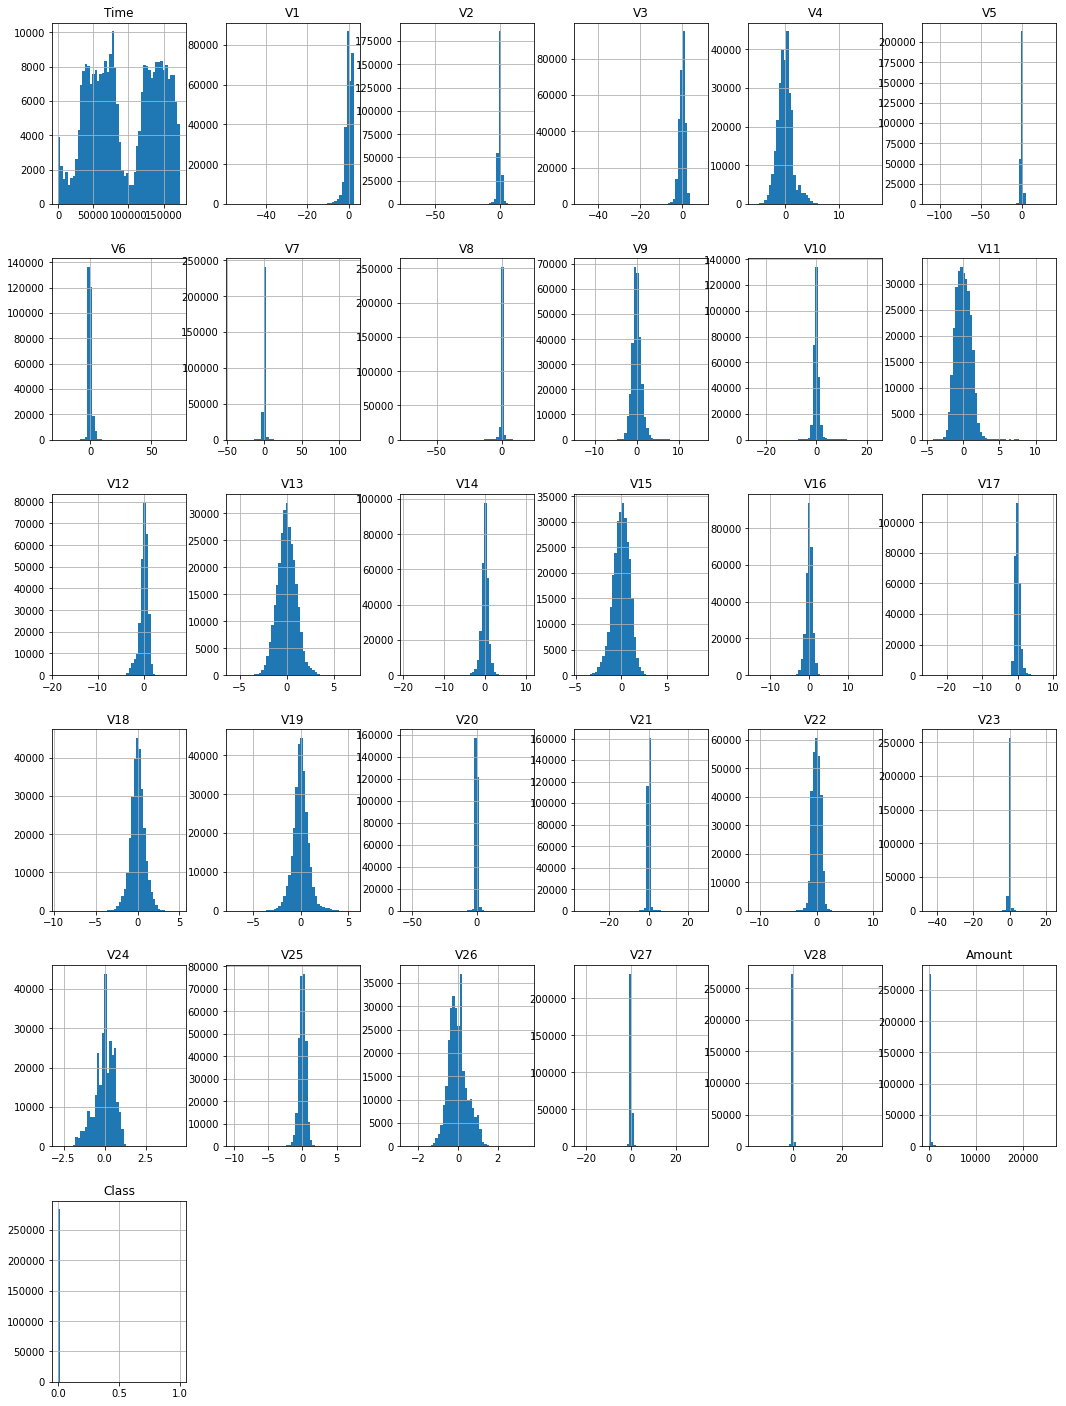

In [4]:
plt.figure(figsize=(12,8))
variables = [x for x in data.columns]
Skewnesss =  data[variables].skew()
data.hist(bins=50, figsize=(18,25))
plt.show()

# Log Transformation 

In [5]:
df = data.copy()
df['Amount'] = [0.001+x for x in data['Amount']]
df['Amount'] = np.log10(df['Amount'])
df = df.drop(['Time'], axis =1)

# Train Test Split

In [6]:
y=df['Class']
x=df.drop('Class',axis=1)
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,shuffle=True)
x_test,x_validation,y_test,y_validation=train_test_split(x_test,y_test,test_size=0.2,shuffle=True)

# Standardize

In [7]:
sc=StandardScaler()
x_train=sc.fit_transform(x_train)
x_test=sc.transform(x_test)
x_validation=sc.transform(x_validation)

# clipping the data

In [8]:
x_train=np.clip(x_train,-5,5)
x_test=np.clip(x_test,-5,5)
x_validation=np.clip(x_validation,-5,5)

# Seperate the dataset based on class

In [9]:
y_train=np.expand_dims(y_train,axis=1)
dataset=np.append(x_train,y_train,axis=1)
dataset=pd.DataFrame(dataset,columns=df.columns)
dataframe0=dataset[dataset['Class']==0]
dataframe1=dataset[dataset['Class']==1]

# joint plot

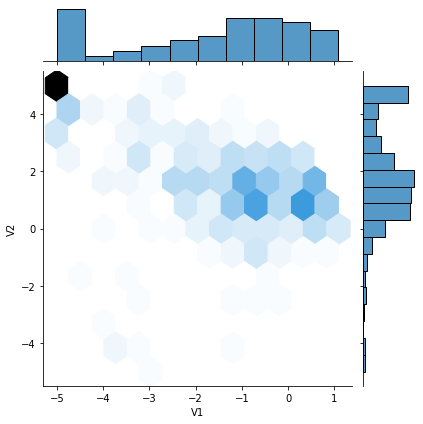

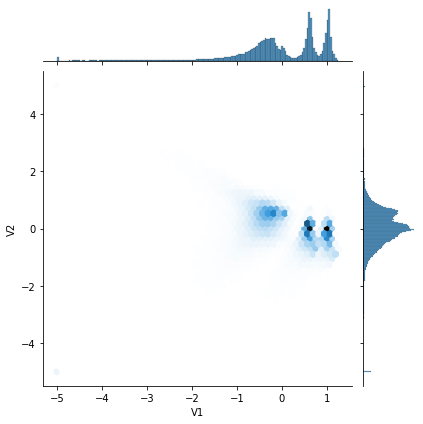

In [10]:
sb.jointplot(data=dataframe1,x="V1",y="V2",kind='hex')
plt.show()
sb.jointplot(data=dataframe0,x="V1",y="V2",kind='hex')
plt.show()

# Build model

In [11]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'),
]

bias=np.log(dataframe1.shape[0]/dataframe0.shape[0])

def probitmodel():
  model=Sequential()
  model.add(Dense(8,activation='relu',input_shape=(29,),bias_initializer=tf.keras.initializers.Constant(bias)))
  model.add(Dropout(0.3))
  model.add(Dense(1,activation='sigmoid',kernel_regularizer='l2'))
  model.compile(loss='binary_crossentropy',optimizer='adam',metrics=METRICS)
  model.summary()
  return model
  

2022-02-09 01:38:35.677280: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-09 01:38:35.707302: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-09 01:38:35.707471: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-09 01:38:35.708018: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

# Train the model

In [21]:
m=probitmodel()
callback=tf.keras.callbacks.EarlyStopping(monitor='val_prc',mode='max',patience=10,restore_best_weights=1)
# m.evaluate(x_test[:10],y_test[:10])
history_0=m.fit(x_train,y_train,validation_data=[x_test,y_test],batch_size=2048,callbacks=callback,epochs=100)


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 8)                 240       
                                                                 
 dropout_4 (Dropout)         (None, 8)                 0         
                                                                 
 dense_9 (Dense)             (None, 1)                 9         
                                                                 
Total params: 249
Trainable params: 249
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
112/112 [==============================] - 2s 8ms/step - loss: 0.6811 - tp: 87.0000 - fp: 10794.0000 - tn: 262148.0000 - fn: 385.0000 - accuracy: 0.9591 - precision: 0.0080 - recall: 0.1843 - auc: 0.6006 - prc: 0.0035 - val_loss: 0.6500 - val_tp: 3.0000 - val_fp: 3.0000 - val_tn: 45484.0000 - val_fn: 79.000

In [31]:
result_matrix1=m.evaluate(x_test,y_test,return_dict=True)
result_matrix1=pd.DataFrame(result_matrix1,index=[0])
result_matrix1

1425/1425 [==============================] - 4s 3ms/step - loss: 0.4498 - tp: 53.0000 - fp: 5.0000 - tn: 45482.0000 - fn: 29.0000 - accuracy: 0.9993 - precision: 0.9138 - recall: 0.6463 - auc: 0.7974 - prc: 0.6409


,loss,tp,fp,tn,fn,accuracy,precision,recall,auc,prc
0,0.449758,53.0,5.0,45482.0,29.0,0.999254,0.913793,0.646341,0.797446,0.640895


# Train the model with class weights

In [23]:
m1=probitmodel()
classweight_0=len(x)/(2*len(y[y==0]))
classweight_1=len(x)/(2*len(y[y==1]))
classweight={0:classweight_0,1:classweight_1}
history_1=m1.fit(x_train,y_train,validation_data=[x_test,y_test],callbacks=callback,epochs=100,batch_size=2048,class_weight=classweight)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 8)                 240       
                                                                 
 dropout_5 (Dropout)         (None, 8)                 0         
                                                                 
 dense_11 (Dense)            (None, 1)                 9         
                                                                 
Total params: 249
Trainable params: 249
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
112/112 [==============================] - 2s 8ms/step - loss: 0.6428 - tp: 355.0000 - fp: 124737.0000 - tn: 148205.0000 - fn: 117.0000 - accuracy: 0.5434 - precision: 0.0028 - recall: 0.7521 - auc: 0.7264 - prc: 0.1991 - val_loss: 0.6922 - val_tp: 54.0000 - val_fp: 57.0000 - val_tn: 45430.0000 - val_fn: 28

112/112 [==============================] - 0s 4ms/step - loss: 0.2966 - tp: 309.0000 - fp: 855.0000 - tn: 226600.0000 - fn: 81.0000 - accuracy: 0.9959 - precision: 0.2655 - recall: 0.7923 - auc: 0.8943 - prc: 0.6417 - val_loss: 0.2891 - val_tp: 67.0000 - val_fp: 168.0000 - val_tn: 45319.0000 - val_fn: 15.0000 - val_accuracy: 0.9960 - val_precision: 0.2851 - val_recall: 0.8171 - val_auc: 0.9151 - val_prc: 0.7391
Epoch 19/100
112/112 [==============================] - 0s 4ms/step - loss: 0.3067 - tp: 304.0000 - fp: 926.0000 - tn: 226529.0000 - fn: 86.0000 - accuracy: 0.9956 - precision: 0.2472 - recall: 0.7795 - auc: 0.8997 - prc: 0.6079 - val_loss: 0.2819 - val_tp: 68.0000 - val_fp: 185.0000 - val_tn: 45302.0000 - val_fn: 14.0000 - val_accuracy: 0.9956 - val_precision: 0.2688 - val_recall: 0.8293 - val_auc: 0.9151 - val_prc: 0.7279
Epoch 20/100
112/112 [==============================] - 0s 4ms/step - loss: 0.3041 - tp: 305.0000 - fp: 1013.0000 - tn: 226442.0000 - fn: 85.0000 - accuracy:

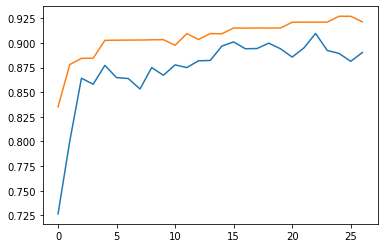

In [24]:
plt.plot(history_1.history['auc'])
plt.plot(history_1.history['val_auc'])
plt.show()

In [30]:
result_matrix2=m1.evaluate(x_test,y_test,return_dict=True)
result_matrix2=pd.DataFrame(result_matrix1,index=[0])
result_matrix2

1425/1425 [==============================] - 4s 3ms/step - loss: 0.2990 - tp: 67.0000 - fp: 151.0000 - tn: 45336.0000 - fn: 15.0000 - accuracy: 0.9964 - precision: 0.3073 - recall: 0.8171 - auc: 0.9150 - prc: 0.7409


,loss,tp,fp,tn,fn,accuracy,precision,recall,auc,prc
0,0.449758,53.0,5.0,45482.0,29.0,0.999254,0.913793,0.646341,0.797446,0.640895


# Oversampling the minority class

oversampling the minority class using SMOTE function that uses KNN approach

In [17]:
sampler=SMOTE(sampling_strategy='minority')
x_resampled,y_resampled=sampler.fit_resample(x_train,y_train)

In [52]:
m2=probitmodel()
classweight={0:1,1:1}
# callback=tf.keras.callbacks.EarlyStopping(monitor='val_prc',patience=5,mode='max',restore_best_weights=1)
m2.evaluate(x_test[:10],y_test[:10])
history_2=m2.fit(x_resampled,y_resampled,batch_size=2048,validation_data=[x_test,y_test],callbacks=callback,epochs=100,class_weight=classweight)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_22 (Dense)            (None, 8)                 240       
                                                                 
 dropout_11 (Dropout)        (None, 8)                 0         
                                                                 
 dense_23 (Dense)            (None, 1)                 9         
                                                                 
Total params: 249
Trainable params: 249
Non-trainable params: 0
_________________________________________________________________
1/1 [==============================] - 1s 502ms/step - loss: 0.7106 - tp: 74.0000 - fp: 1158.0000 - tn: 44339.0000 - fn: 8.0000 - accuracy: 0.9744 - precision: 0.0601 - recall: 0.9024 - auc: 0.9665 - prc: 0.7751
Epoch 1/100
223/223 [==============================] - 2s 4ms/step - loss: 0.5522 - tp: 132286.0000 - fp: 1

223/223 [==============================] - 1s 4ms/step - loss: 0.2315 - tp: 183444.0000 - fp: 2125.0000 - tn: 225330.0000 - fn: 44011.0000 - accuracy: 0.8986 - precision: 0.9885 - recall: 0.8065 - auc: 0.9521 - prc: 0.9610 - val_loss: 0.1368 - val_tp: 71.0000 - val_fp: 328.0000 - val_tn: 45159.0000 - val_fn: 11.0000 - val_accuracy: 0.9926 - val_precision: 0.1779 - val_recall: 0.8659 - val_auc: 0.9670 - val_prc: 0.6590
Epoch 18/100
223/223 [==============================] - 1s 4ms/step - loss: 0.2266 - tp: 184154.0000 - fp: 2217.0000 - tn: 225238.0000 - fn: 43301.0000 - accuracy: 0.8999 - precision: 0.9881 - recall: 0.8096 - auc: 0.9547 - prc: 0.9628 - val_loss: 0.1326 - val_tp: 71.0000 - val_fp: 346.0000 - val_tn: 45141.0000 - val_fn: 11.0000 - val_accuracy: 0.9922 - val_precision: 0.1703 - val_recall: 0.8659 - val_auc: 0.9645 - val_prc: 0.6614
Epoch 19/100
223/223 [==============================] - 1s 4ms/step - loss: 0.2238 - tp: 184423.0000 - fp: 2303.0000 - tn: 225152.0000 - fn: 43

In [53]:
result_matrix3=m2.evaluate(x_test,y_test,return_dict=True)
result_matrix3=pd.DataFrame(result_matrix3,index=[0])
result_matrix3

1425/1425 [==============================] - 4s 3ms/step - loss: 0.1713 - tp: 69.0000 - fp: 195.0000 - tn: 45292.0000 - fn: 13.0000 - accuracy: 0.9954 - precision: 0.2614 - recall: 0.8415 - auc: 0.9599 - prc: 0.7573


,loss,tp,fp,tn,fn,accuracy,precision,recall,auc,prc
0,0.171332,69.0,195.0,45292.0,13.0,0.995435,0.261364,0.841463,0.959945,0.757302


## Final result

In [54]:
output=pd.concat((result_matrix1,result_matrix2,result_matrix3),axis=0)
output

,loss,tp,fp,tn,fn,accuracy,precision,recall,auc,prc
0,0.449758,53.0,5.0,45482.0,29.0,0.999254,0.913793,0.646341,0.797446,0.640895
0,0.449758,53.0,5.0,45482.0,29.0,0.999254,0.913793,0.646341,0.797446,0.640895
0,0.171332,69.0,195.0,45292.0,13.0,0.995435,0.261364,0.841463,0.959945,0.757302
